# Pavement Condition Monitoring and Maintenance Prediction

Muh Amri Sidiq

## Introduction

Road infrastructure plays a vital role in economic development, mobility, and public safety. Ensuring that roads are maintained in good condition is a constant challenge, especially under constraints of limited budget, heavy traffic loads, and varying environmental conditions.

In this project, I analyze the Pavement Dataset, which includes road segment data such as Pavement Condition Index (PCI), traffic volume (AADT), asphalt type, rutting, roughness index (IRI), rainfall, and past maintenance records. The main objective is to predict whether a road segment requires urgent maintenance using data-driven insights.

By exploring patterns between road conditions and maintenance needs, I aim to:
- Identify key factors contributing to pavement deterioration
- Build predictive models to support preventive maintenance planning
- Provide actionable recommendations to optimize road maintenance schedules

This portfolio demonstrates the application of data analytics and machine learning to improve decision-making in civil infrastructure management.

## Import Library

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import shap
from sklearn.preprocessing import OrdinalEncoder
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Import, Read Data & Understanding

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gifreysulay/pavement-dataset")

print("Path to dataset files:", path)

100%|██████████| 19.9M/19.9M [00:00<00:00, 63.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gifreysulay/pavement-dataset/versions/1


In [3]:
# List files in the downloaded dataset folder
for file in os.listdir(path):
    print(file)

file_path = os.path.join(path, 'ESC 12 Pavement Dataset.csv')

pavement = pd.read_csv(file_path)

ESC 12 Pavement Dataset.csv


check preview data

In [4]:
pavement.head()

,Segment ID,PCI,Road Type,AADT,Asphalt Type,Last Maintenance,Average Rainfall,Rutting,IRI,Needs Maintenance
0,SID 155440,70.00,Secondary,4634,Concrete,2022,42.07,15.11,0.68,0
1,SID 244365,37.87,Tertiary,3474,Asphalt,2017,79.60,19.67,0.99,1
2,SID 137867,88.32,Tertiary,1734,Concrete,2019,62.69,14.73,0.50,0
3,SID 540519,52.30,Tertiary,3119,Asphalt,2008,79.32,17.01,1.04,1
4,SID 745776,49.10,Tertiary,3505,Asphalt,2019,71.81,21.08,1.18,1


In [5]:
pavement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050000 entries, 0 to 1049999
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Segment ID         1050000 non-null  object 
 1   PCI                1050000 non-null  float64
 2   Road Type          1050000 non-null  object 
 3   AADT               1050000 non-null  int64  
 4   Asphalt Type       1050000 non-null  object 
 5   Last Maintenance   1050000 non-null  int64  
 6   Average Rainfall   1050000 non-null  float64
 7   Rutting            1050000 non-null  float64
 8   IRI                1050000 non-null  float64
 9   Needs Maintenance  1050000 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 80.1+ MB


Insight: Data have 1.050.000 row and 10 clumns, explain this bellow:

 - `Segment ID` :	Unique identifier for the road segment
 - `PCI`:	Pavement Condition Index (0 = worst, 100 = best)
 - `Road Type`:	Type of road (Primary, Secondary, Barangay)
 - `AADT`: Average Annual Daily Traffic
 - `Asphalt Type`:	Asphalt mix classification (e.g. Dense, Open-graded, SMA)
 - `Last Maintenance`:	Year of the last major maintenance
 - `Average Rainfall`:	Average annual rainfall in the area (mm)
 - `Rutting`:	Depth of rutting (mm)
 - `IRI`	International Roughness Index (m/km)
 - `Needs Maintenance`:	Target label: 1 if urgent maintenance is needed, 0 otherwise

In [6]:
pavement.duplicated().sum()

np.int64(0)

Data no have duplicated

## Exploratory Data Analysis
Exploratory Data Analysis (EDA) is the process of analyzing and summarizing datasets to understand their main characteristics before applying machine learning models or statistical tests. EDA helps identify patterns, detect anomalies, check assumptions, and gain insights using visualizations and statistical methods

In [7]:
pavement.describe()

,PCI,AADT,Last Maintenance,Average Rainfall,Rutting,IRI,Needs Maintenance
count,1.050000e+06,1.050000e+06,1.050000e+06,1.050000e+06,1.050000e+06,1.050000e+06,1.050000e+06
mean,5.470744e+01,1.155683e+04,2.018147e+03,6.498192e+01,1.659194e+01,8.500802e-01,4.998752e-01
std,2.877674e+01,1.389092e+04,4.984028e+00,1.802855e+01,2.891353e+00,2.366776e-01,5.000002e-01
min,0.000000e+00,-1.931300e+04,1.959000e+03,0.000000e+00,7.220000e+00,-2.800000e-01,0.000000e+00
25%,2.998000e+01,2.288000e+03,2.017000e+03,4.996000e+01,1.400000e+01,6.900000e-01,0.000000e+00
50%,5.502000e+01,5.307000e+03,2.019000e+03,6.497000e+01,1.703000e+01,8.500000e-01,0.000000e+00
75%,8.007000e+01,1.644100e+04,2.021000e+03,8.003000e+01,1.920000e+01,1.010000e+00,1.000000e+00
max,1.000000e+02,2.001500e+05,2.028000e+03,1.298400e+02,2.409000e+01,1.910000e+00,1.000000e+00


Data have minus/negatif with column `AADT` and `IRI`

In [8]:
pavement.describe(include='object')

,Segment ID,Road Type,Asphalt Type
count,1050000,1050000,1050000
unique,1050000,3,2
top,SID 212513,Tertiary,Concrete
freq,1,489465,525294


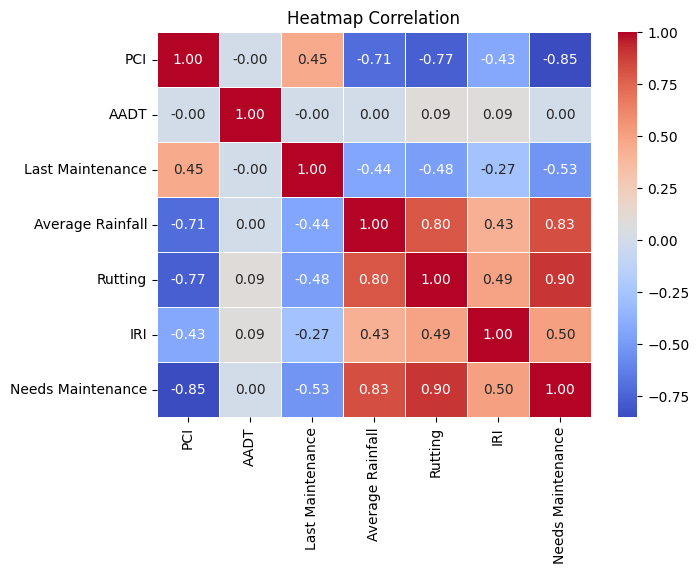

In [9]:
pavement_numeric = pavement.select_dtypes(include=['number'])

# Calculate correlation
corr_matrix = pavement_numeric.corr()

# Plot heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap Correlation")
plt.show()

Insight: `PCI` and `Last Maintenance` have storng correlation negative to `Needs Maintenance`, `Average Rainfall`, `Rutting` and `IRI` have strong correlation positive to `Needs Maintenance`

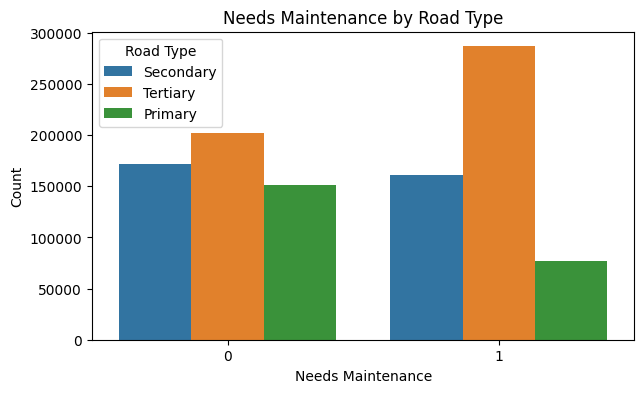

In [10]:
plt.figure(figsize=(7, 4))
sns.countplot(x='Needs Maintenance', hue='Road Type', data=pavement)
plt.title('Needs Maintenance by Road Type')
plt.xlabel('Needs Maintenance')
plt.ylabel('Count')
plt.show()

Insight: `Road Type` Tertiary have highest in all type `Needs Maintenance` and `Road Type` Primary have lowest in all type `Needs Maintenance`

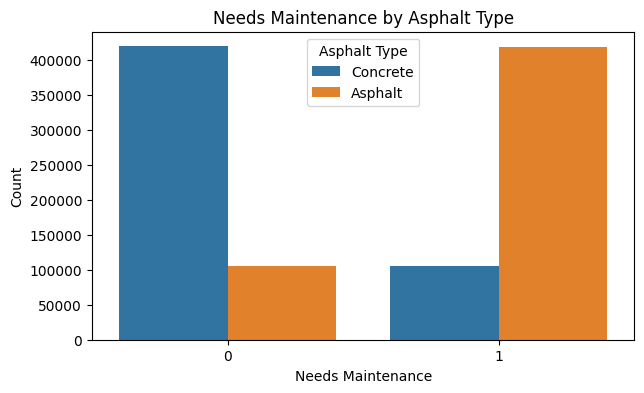

In [11]:
plt.figure(figsize=(7, 4))
sns.countplot(x='Needs Maintenance', hue='Asphalt Type', data=pavement)
plt.title('Needs Maintenance by Asphalt Type')
plt.xlabel('Needs Maintenance')
plt.ylabel('Count')
plt.show()

Insight: `Asphalt Type` Concreate have count highest in `Needs Maintenance` Type 0 and `Asphalt Type` Asphalt have count highest in `Needs Maintenance` Type 1

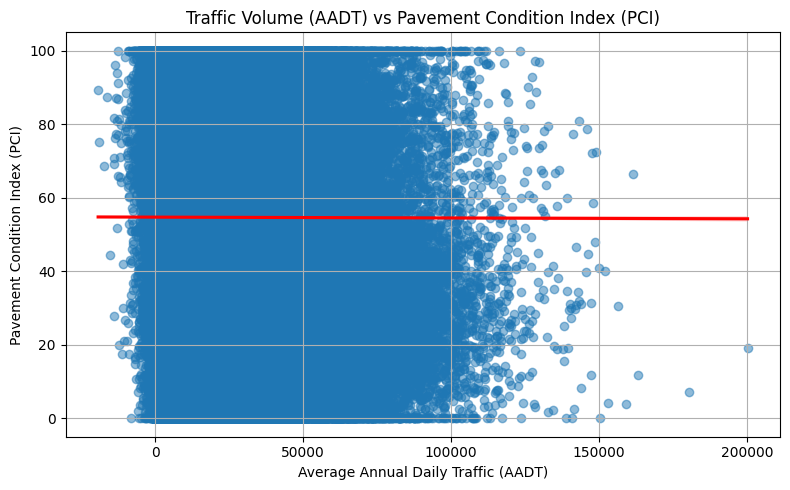

In [12]:
# Plot AADT vs PCI
plt.figure(figsize=(8, 5))
sns.regplot(data=pavement, x='AADT', y='PCI', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title("Traffic Volume (AADT) vs Pavement Condition Index (PCI)")
plt.xlabel("Average Annual Daily Traffic (AADT)")
plt.ylabel("Pavement Condition Index (PCI)")
plt.grid(True)
plt.tight_layout()
plt.show()

Insight:No have correlation

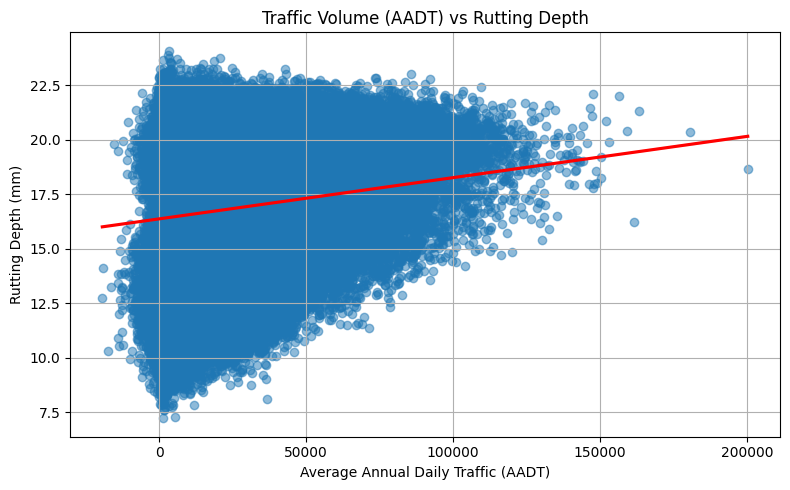

In [13]:
# Plot AADT vs Rutting
plt.figure(figsize=(8, 5))
sns.regplot(data=pavement, x='AADT', y='Rutting', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title("Traffic Volume (AADT) vs Rutting Depth")
plt.xlabel("Average Annual Daily Traffic (AADT)")
plt.ylabel("Rutting Depth (mm)")
plt.grid(True)
plt.tight_layout()
plt.show()

Insight: if the value of `Rutting` rises then `AADT` rises too, so it can be interpreted that the two have a strong positive relationship.

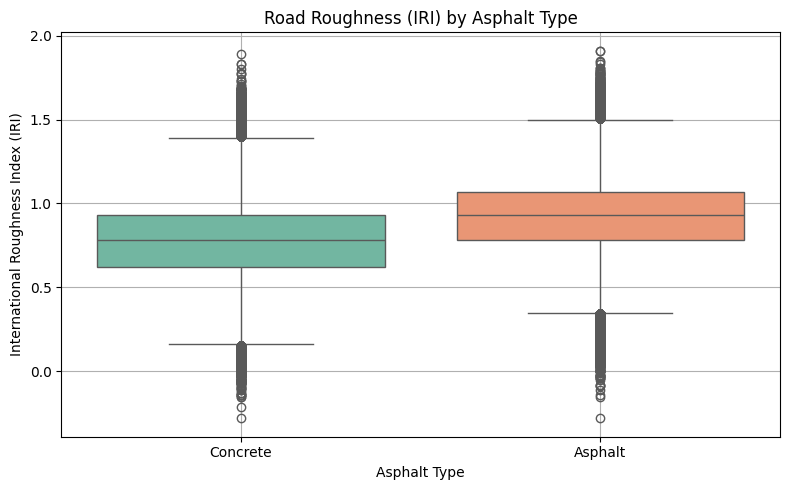

In [14]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=pavement, x='Asphalt Type', y='IRI', palette='Set2')
plt.title("Road Roughness (IRI) by Asphalt Type")
plt.xlabel("Asphalt Type")
plt.ylabel("International Roughness Index (IRI)")
plt.grid(True)
plt.tight_layout()
plt.show()

Insight: `Asphalt Type` Asphalt have higher median `IRI`

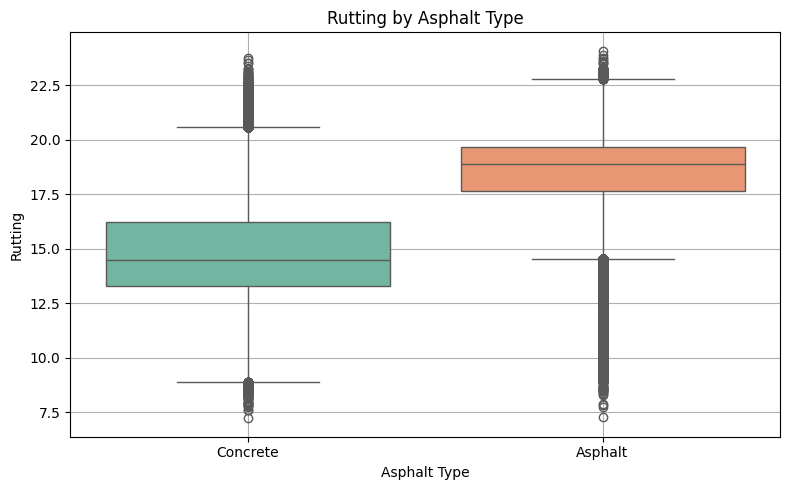

In [15]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=pavement, x='Asphalt Type', y='Rutting', palette='Set2')
plt.title("Rutting by Asphalt Type")
plt.xlabel("Asphalt Type")
plt.ylabel("Rutting")
plt.grid(True)
plt.tight_layout()
plt.show()

Insight: `Asphalt Type` Asphalt have higher median `Rutting`

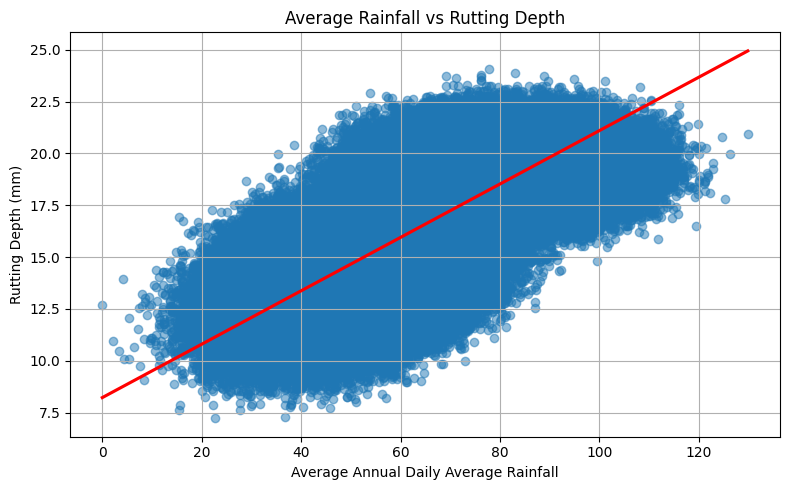

In [16]:
# Plot AADT vs Rutting
plt.figure(figsize=(8, 5))
sns.regplot(data=pavement, x='Average Rainfall', y='Rutting', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title("Average Rainfall vs Rutting Depth")
plt.xlabel("Average Annual Daily Average Rainfall")
plt.ylabel("Rutting Depth (mm)")
plt.grid(True)
plt.tight_layout()
plt.show()

Insight: if the value of `Rutting` rises then `Average Rainfall` rises too, so it can be interpreted that the two have a strong positive relationship.

## Feature Engineering

Feature Engineering is the process of transforming raw data into more relevant and informative features (input variables) so that Machine Learning (ML) models can learn more effectively and produce more accurate predictions. It is one of the crucial stages in the Machine Learning project lifecycle, and is often referred to as the “art” in Data Science because it requires a combination of technical expertise, domain understanding, and creativity.

we assume that this year is the time to analyze

In [17]:
pavement['Years Since Maintenance'] = 2025 - pavement['Last Maintenance']

If the road is over 10 years old and has not been repaired, we consider the road to be old.

In [18]:
pavement['Is Old Road'] = pavement['Years Since Maintenance'] > 10

Group traffic into Low, Medium, High levels, and `AADT` should not have any negative values

In [19]:
pavement['AADT'] = pavement['AADT'].apply(lambda x: x if x >= 0 else np.nan)
pavement['AADT'].fillna(pavement['AADT'].median(), inplace=True)

pavement['Traffic Level'] = pd.cut(pavement['AADT'],
    bins=[-0.1, 5000, 15000, pavement['AADT'].max()],
    labels=['Low', 'Medium', 'High'])

classification PCI to:
 - Good (≥ 70)
 - Fair (50–69)
 - Poor (< 50)

In [20]:
def categorize_pci(pci):
    if pci <= 40:
        return 'Poor'
    elif pci <= 70:
        return 'Fair'
    else:
        return 'Good'

pavement['PCI_Class'] = pavement['PCI'].apply(categorize_pci)

Classification `Average rainfall`

In [21]:
def categorize_rainfall(rainfall):
    if rainfall < 50:
        return 'Low'
    elif 50 <= rainfall <= 75:
        return 'Medium'
    else:
        return 'High'

pavement['Rainfall Category'] = pavement['Average Rainfall'].apply(categorize_rainfall)

Combine `Year Since Maintenance` with `Average Rainfall`, `Year Since Maintenance` with `Rutting`, `Year Since Maintenance` with `IRI` and `Year Since Maintenance` with `PCI`

In [22]:
pavement['Age_Rain_Interaction'] = pavement['Years Since Maintenance'] * pavement['Average Rainfall']
pavement['Age_Rutting_Interaction'] = pavement['Years Since Maintenance'] * pavement['Rutting']
pavement['Age_IRI_Interaction'] = pavement['Years Since Maintenance'] * pavement['IRI']
pavement['Age_PCI_Interaction'] = pavement['Years Since Maintenance'] * pavement['PCI']

Severity Factor

In [23]:
pavement['Severity_Factor'] = (100 - pavement['PCI']) / 100

Road length simulation

In [24]:
np.random.seed(101)
pavement['Road_Length_km'] = np.random.uniform(10, 100, size=len(pavement))

Mapping cost by km, estimated Cost and cost efficiency

In [27]:
cost_map = {
    ('Primary', 'Asphalt'): 70000,
    ('Primary', 'Concrete'): 90000,
    ('Secondary', 'Asphalt'): 50000,
    ('Secondary', 'Concrete'): 70000,
    ('Tertiary', 'Asphalt'): 30000,
    ('Tertiary', 'Concrete'): 45000
}

pavement['Road Type'] = pavement['Road Type'].str.strip()
pavement['Asphalt Type'] = pavement['Asphalt Type'].str.strip()

# Make column merge
pavement['Road_Asphalt_Key'] = list(zip(pavement['Road Type'], pavement['Asphalt Type']))

# Mapping to cost by km
pavement['Cost_per_km'] = pavement['Road_Asphalt_Key'].map(cost_map).fillna(40000)

In [28]:
pavement['Estimated_Cost'] = (
    pavement['Road_Length_km'] *
    pavement['Cost_per_km']
)

In [29]:
pavement['Cost_Efficiency'] = np.where(
    pavement['Severity_Factor'] == 0, 0,
    pavement['Estimated_Cost'] / (
        pavement['Road_Length_km'].clip(lower=0.01) *
        pavement['Severity_Factor'].clip(lower=0.01) *
        (1 + pavement['Rutting'].fillna(0)/10) *
        (1 + pavement['IRI'].fillna(0)/2)
    )
)

change data type object to on-hot encoding

In [30]:
pavement = pd.get_dummies(pavement, columns=['Road Type', 'Asphalt Type'], drop_first=True)

Label Encoding (for category ordinal)

In [31]:
ordinal_cols = ['Traffic Level', 'PCI_Class', 'Rainfall Category']
encoder = OrdinalEncoder(categories=[['Low', 'Medium', 'High'],
                                     ['Poor', 'Fair', 'Good'],
                                     ['Low', 'Medium', 'High']])
pavement[ordinal_cols] = encoder.fit_transform(pavement[ordinal_cols])

## Preparation Data

In [32]:
x = pavement.drop(['Needs Maintenance', 'Segment ID','Road_Asphalt_Key'], axis=1)
y = pavement['Needs Maintenance']

## Modeling

Before modeling applied, split data train and data validation to train model

In [33]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in kf.split(x):
    x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

In [34]:
model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Latih model
model.fit(x_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:09:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

<Figure size 1000x600 with 0 Axes>

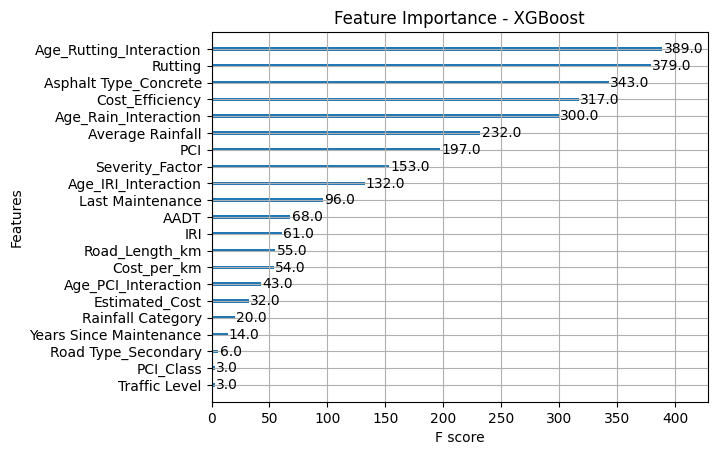

In [35]:
# Feature Importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, importance_type='weight')
plt.title("Feature Importance - XGBoost")
plt.show()

Insight: `Rutting` have highest feature importance

## Evaluation

In [36]:
y_pred = model.predict(x_val)
y_pred_proba = model.predict_proba(x_val)[:, 1]

print("Accuracy of Conversion Prediction Model:", accuracy_score(y_val, y_pred))
print("AUC Score:", roc_auc_score(y_val, y_pred_proba))
print("Report Classification:")
print(classification_report(y_val, y_pred))

Accuracy of Conversion Prediction Model: 0.9999809523809524
AUC Score: 0.9999999980952369
Report Classification:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105083
           1       1.00      1.00      1.00    104917

    accuracy                           1.00    210000
   macro avg       1.00      1.00      1.00    210000
weighted avg       1.00      1.00      1.00    210000



Confusion Matrix:
[[105080      3]
 [     1 104916]]


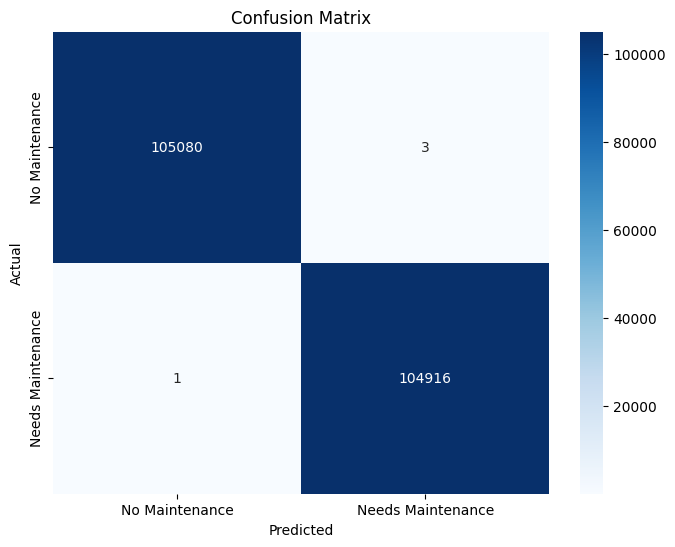

Classification Report:
                   precision    recall  f1-score   support

   No Maintenance       1.00      1.00      1.00    105083
Needs Maintenance       1.00      1.00      1.00    104917

         accuracy                           1.00    210000
        macro avg       1.00      1.00      1.00    210000
     weighted avg       1.00      1.00      1.00    210000



In [37]:
cm = confusion_matrix(y_val, y_pred)

# Print matrix numerik
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Maintenance', 'Needs Maintenance'],
            yticklabels=['No Maintenance', 'Needs Maintenance'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=['No Maintenance', 'Needs Maintenance']))

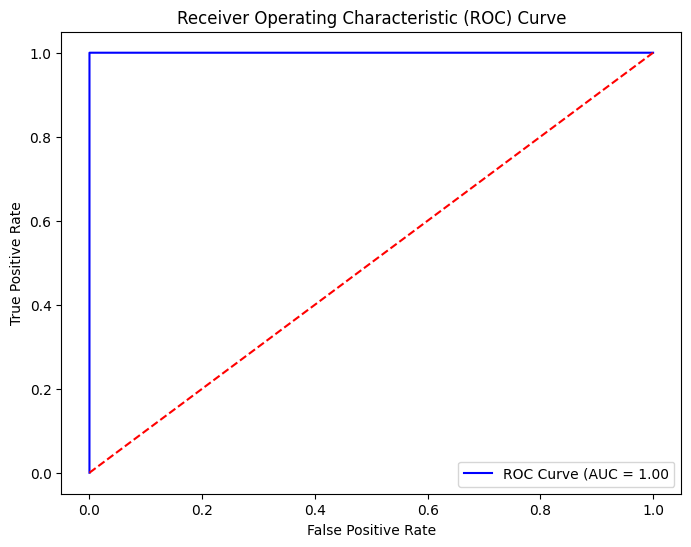

In [38]:
# Plot AUC (ROC Curve)
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc_score(y_val, y_pred_proba):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

Insight: Accuration model is 100% with AUC score 1

## Cost Optimization Strategy

Streamline repair budget with repair prioritization

In [39]:
x_val = x_val.copy()
x_val['Predicted'] = y_pred

# Take only prediction = 1 (need Maintenance)
predicted_df = x_val[x_val['Predicted'] == 1].copy()
predicted_df['Estimated_Cost'] = pavement.loc[predicted_df.index, 'Estimated_Cost']
predicted_df['Cost_Efficiency'] = pavement.loc[predicted_df.index, 'Cost_Efficiency']

# Segment ranking based on efficiency
prioritized = predicted_df.sort_values(by='Cost_Efficiency')

# Simulation: limited budget allocation
BUDGET = 1_000_000_000  # example budget
prioritized['Cumulative_Cost'] = prioritized['Estimated_Cost'].cumsum()

selected = prioritized[prioritized['Cumulative_Cost'] <= BUDGET]

print(f"Total segments repaired: {len(selected)}")
print(f"Total estimated cost used: ${selected['Estimated_Cost'].sum():,.2f}")

Total segments repaired: 618
Total estimated cost used: $999,715,066.14


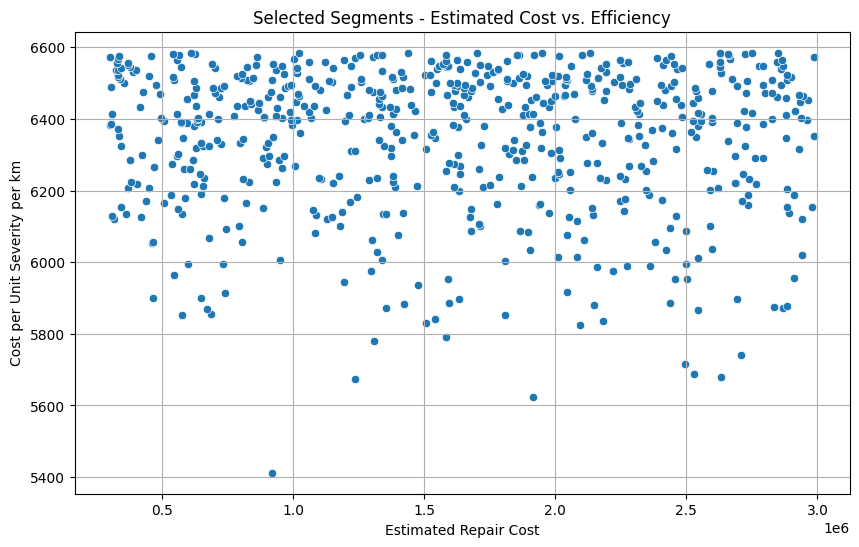

In [40]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=selected, x='Estimated_Cost', y='Cost_Efficiency')
plt.title("Selected Segments - Estimated Cost vs. Efficiency")
plt.xlabel("Estimated Repair Cost")
plt.ylabel("Cost per Unit Severity per km")
plt.grid(True)
plt.show()

## Business Conclusions and Benefits

 - Predictive models can identify damaged roads with good accuracy.
 - A prioritization strategy based on cost efficiency allows for significant savings.
 - With a fixed budget, agencies can repair more roads if they choose based on `Cost_Efficiency`.

## ROI Analysis – Return on Investment

Measure the efficiency and long-term savings of prioritized road improvement decisions based on cost prediction and optimization results.

Basic assumptions for ROI simulation:
 - Improvements reduce the likelihood of severe damage and increase the life of the road by 5 years.
 - Cost of damage if not repaired = X per km per year (e.g. emergency maintenance costs or economic loss).
 - ROI efficiency is calculated from the avoided cost compared to the actual cost of the improvement.

In [41]:
# Simulation of limited budget allocation
BUDGET = 80_000_000  # example budget
prioritized['Cumulative_Cost'] = prioritized['Estimated_Cost'].cumsum()

# Make a secure copy
selected = prioritized[prioritized['Cumulative_Cost'] <= BUDGET].copy()

# Assumed cost of damage if not repaired (by km by year)
damage_cost_per_km_per_year = 18000  # example: 18 ribu USD/km/year
life_extension_years = 5

# Calculate potential avoided costs
selected['Avoided_Cost'] = (
    selected['Road_Length_km'] *
    damage_cost_per_km_per_year *
    life_extension_years *
    selected['Severity_Factor']
)

# ROI = (Benefit - Cost) / Cost
selected['ROI'] = (selected['Avoided_Cost'] - selected['Estimated_Cost']) / selected['Estimated_Cost']

# Summary of results
average_roi = selected['ROI'].mean()
total_avoided_cost = selected['Avoided_Cost'].sum()
total_repair_cost = selected['Estimated_Cost'].sum()

print(f"Total segments repaired: {len(selected)}")
print(f"Total repair cost used: ${total_repair_cost:,.2f}")
print(f"Total avoided cost over {life_extension_years} years: ${total_avoided_cost:,.2f}")
print(f"Average ROI across selected roads: {average_roi:.2f}")

Total segments repaired: 44
Total repair cost used: $79,697,428.03
Total avoided cost over 5 years: $237,438,078.54
Average ROI across selected roads: 1.98


In [42]:
def simulate_delay_costs(df, max_years=5, damage_degradation_per_year=5, cost_increase_rate=0.1):
    simulation_results = []

    for delay in range(1, max_years + 1):
        df_sim = df.copy()

        # PCI drops every year of delay
        df_sim['Delayed_PCI'] = df_sim['PCI'] - delay * damage_degradation_per_year
        df_sim['Delayed_PCI'] = df_sim['Delayed_PCI'].clip(lower=0)  # PCI cannot be negative

        # Severity increase
        df_sim['Delayed_Severity'] = (100 - df_sim['Delayed_PCI']) / 100

        # Cost increase 10% by years
        df_sim['Delayed_Cost_per_km'] = df_sim['Cost_per_km'] * ((1 + cost_increase_rate) ** delay)

        # Estimate cost new
        df_sim['Delayed_Estimated_Cost'] = (
            df_sim['Road_Length_km'] *
            df_sim['Delayed_Cost_per_km'] *
            df_sim['Delayed_Severity']
        )

        # Avoided costs remain the same (assumption of equal risk)
        df_sim['Avoided_Cost'] = (
            df_sim['Road_Length_km'] *
            15000 * 5 *  # 5 years of economic value assumption avoided
            df_sim['Delayed_Severity']
        )

        # New ROI
        df_sim['ROI_after_delay'] = (df_sim['Avoided_Cost'] - df_sim['Delayed_Estimated_Cost']) / df_sim['Delayed_Estimated_Cost']

        simulation_results.append({
            'Years_Delayed': delay,
            'Avg_PCI': df_sim['Delayed_PCI'].mean(),
            'Avg_Estimated_Cost': df_sim['Delayed_Estimated_Cost'].mean(),
            'Total_Cost': df_sim['Delayed_Estimated_Cost'].sum(),
            'Avg_ROI': df_sim['ROI_after_delay'].mean()
        })

    return pd.DataFrame(simulation_results)


In [43]:
delay_df = simulate_delay_costs(selected)
print(delay_df)

   Years_Delayed  Avg_PCI  Avg_Estimated_Cost    Total_Cost   Avg_ROI
0              1   0.0025        1.992400e+06  8.766559e+07  1.272727
1              2   0.0000        2.191679e+06  9.643389e+07  1.066116
2              3   0.0000        2.410847e+06  1.060773e+08  0.878287
3              4   0.0000        2.651932e+06  1.166850e+08  0.707534
4              5   0.0000        2.917125e+06  1.283535e+08  0.552303


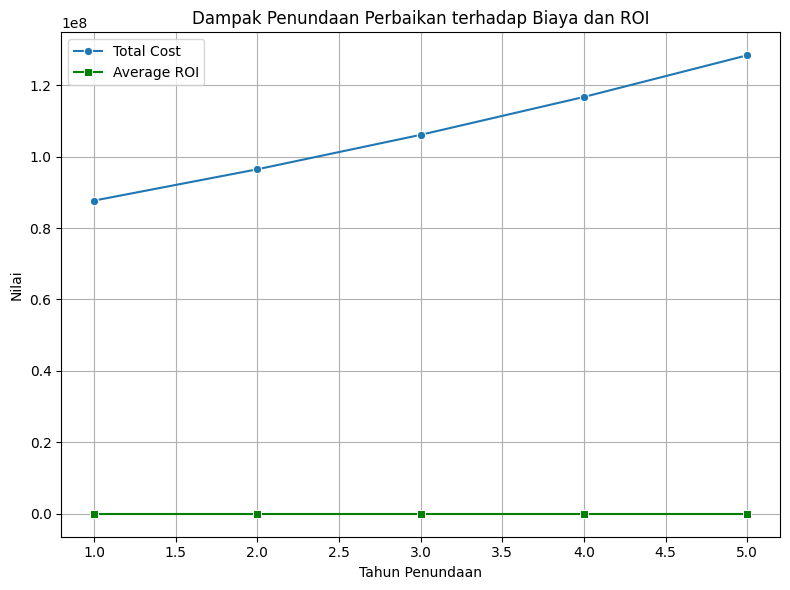

In [44]:
plt.figure(figsize=(8,6))
sns.lineplot(data=delay_df, x='Years_Delayed', y='Total_Cost', marker='o', label='Total Cost')
sns.lineplot(data=delay_df, x='Years_Delayed', y='Avg_ROI', marker='s', label='Average ROI', color='green')
plt.title("Dampak Penundaan Perbaikan terhadap Biaya dan ROI")
plt.xlabel("Tahun Penundaan")
plt.ylabel("Nilai")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Conclussion

`PCI` and `Last Maintenance` have storng correlation negative to `Needs Maintenance`, `Average Rainfall`, `Rutting` and `IRI` have strong correlation positive to `Needs Maintenance`. `Road Type` Tertiary have highest in all type `Needs Maintenance` and `Road Type` Primary have lowest in all type `Needs Maintenance`. `Asphalt Type` Concreate have count highest in `Needs Maintenance` Type 0 and `Asphalt Type` Asphalt have count highest in `Needs Maintenance` Type 1. if the value of `Rutting` rises then `AADT` rises too, so it can be interpreted that the two have a strong positive relationship. if the value of `Rutting` rises then `Average Rainfall` rises too, so it can be interpreted that the two have a strong positive relationship. Highest feature importance value is `Age_Rutting_Interaction`, with accuracy model is 100%. We simlate with ROI 1.98 and if

## Reference

1. https://scikit-learn.org/stable/
2. https://xgboost.readthedocs.io/en/stable/
3. https://kaggle.com/

## Contact

[Linkedin](http://linkedin.com/in/muh-amri-sidiq)